# Welcome

In this exercises notebook you are going to do another small hackathon. The dataset is in `data`. You have to unzip the file and look for the `propublica_data_for_fairml.csv` file. 

Your objective is to train an ML model on this data, and then apply what you've learned in this unit about Bias and Fairness and use the python toolkit [Aequitas](https://github.com/dssg/aequitas) to analyze your ML model's fairness.

# Dataset Overview - COMPAS Recidivism Racial Bias

COMPAS (Correctional Offender Management Profiling for Alternative Sanctions) is a popular commercial algorithm used by judges and parole officers for scoring criminal defendant’s likelihood of reoffending (recidivism). It has been shown that the algorithm is biased in favor of white defendants, and against black inmates, based on a 2 year follow up study (i.e who actually committed crimes or violent crimes after 2 years). The pattern of mistakes, as measured by precision/sensitivity is notable.


Data contains variables used by the COMPAS algorithm in scoring defendants, along with their outcomes within 2 years of the decision, for over 10,000 criminal defendants in Broward County, Florida.

3 subsets of the data are provided, including a subset of only violent recividism (as opposed to, e.g. being reincarcerated for non violent offenses such as vagrancy or Marijuana).

# Objectives

1. Read and clean the data
2. Perform Exploratory Data Analysis to understand the data 
    1. What are the sensitive attributes of this dataset? 
    2. What is the age distribution? 
    3. What is the etnicity distribution and prevalence on each group?
3. Fit a logistic regression with the default parameters and summarize the model's performance on a validation set (precision, recall, f1)
5. **Most Important** Use Aequitas to analyze potential biases your model might have. You have here the freedom to explore the Aequitas tool hands-on and provide interesting fairness analyses.
6. (if you still have remaining time) perform hyperparameter optimization through cross validation with a Random Forest and obtain a model that performs better than your Logistic regression.
7. Redo your fairness analysis and report any major differences in fairness that you found between the two models.

In [42]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score,accuracy_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [44]:
df = pd.read_csv(r'C:\Users\JoaoViegas\OneDrive - FCT NOVA\curso_ai\5th-edition\Metrics & Fairness\Bias & Fairness\data\propublicaCompassRecividism_data_fairml.csv\propublica_data_for_fairml.csv')#,index_col='Time')
df.head()

,Two_yr_Recidivism,Number_of_Priors,score_factor,Age_Above_FourtyFive,Age_Below_TwentyFive,African_American,Asian,Hispanic,Native_American,Other,Female,Misdemeanor
0,0,0,0,1,0,0,0,0,0,1,0,0
1,1,0,0,0,0,1,0,0,0,0,0,0
2,1,4,0,0,1,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,0,1
4,1,14,1,0,0,0,0,0,0,0,0,0


In [45]:
df.shape

(6172, 12)

In [46]:
df.isna().sum()

Two_yr_Recidivism       0
Number_of_Priors        0
score_factor            0
Age_Above_FourtyFive    0
Age_Below_TwentyFive    0
African_American        0
Asian                   0
Hispanic                0
Native_American         0
Other                   0
Female                  0
Misdemeanor             0
dtype: int64

<Figure size 1000x500 with 0 Axes>

<AxesSubplot:>

Text(0.5, 1.0, 'Distribution of Ages')

(array([0, 1, 2]),
 [Text(0, 0, 'Age_Below_TwentyFive'),
  Text(1, 0, 'Age_Above_FourtyFive'),
  Text(2, 0, 'Between_25_45')])

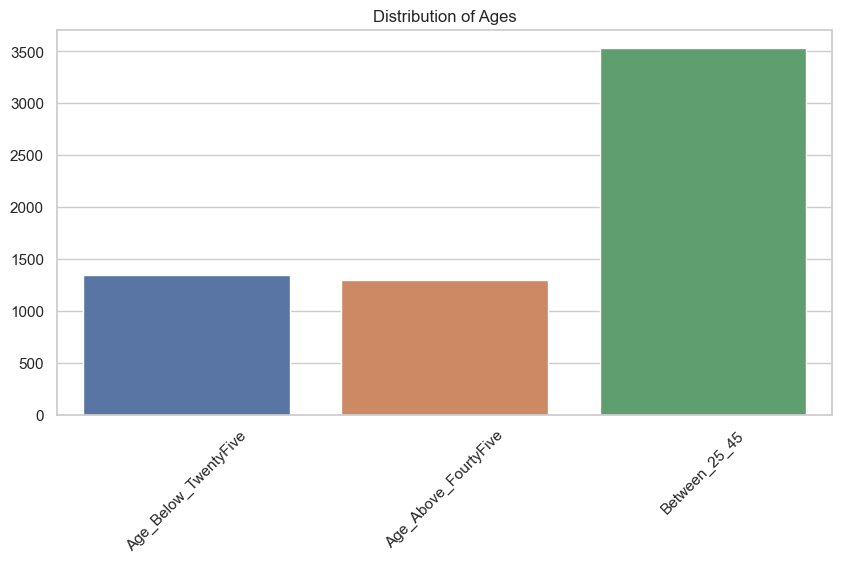

In [47]:
# Count the number of 1 values in the 'your_column' column
count_age_below_25 = (df['Age_Below_TwentyFive'] == 1).sum()
count_age_above_45 = (df['Age_Above_FourtyFive'] == 1).sum()
num_rows, num_columns = df.shape
count_age_between_25_45 = num_rows - count_age_below_25 - count_age_above_45


# Replace these with your actual data
column_names = ['Age_Below_TwentyFive', 'Age_Above_FourtyFive', 'Between_25_45']
counts_of_ones = [count_age_below_25, count_age_above_45, count_age_between_25_45]

# Create a bar plot to visualize the distribution
sns.set(style="whitegrid")
plt.figure(figsize=(10, 5))  # Set the figure size

# Use seaborn's barplot to create the distribution plot
sns.barplot(x=column_names, y=counts_of_ones)

# Customize the plot, including labels and title
plt.title('Distribution of Ages')


# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=45)

# Show the plot
plt.show()


<Figure size 1000x500 with 0 Axes>

<AxesSubplot:>

Text(0.5, 1.0, 'Distribution of Race')

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'African'),
  Text(1, 0, 'Asian'),
  Text(2, 0, 'Hispanic'),
  Text(3, 0, 'American'),
  Text(4, 0, 'Other')])

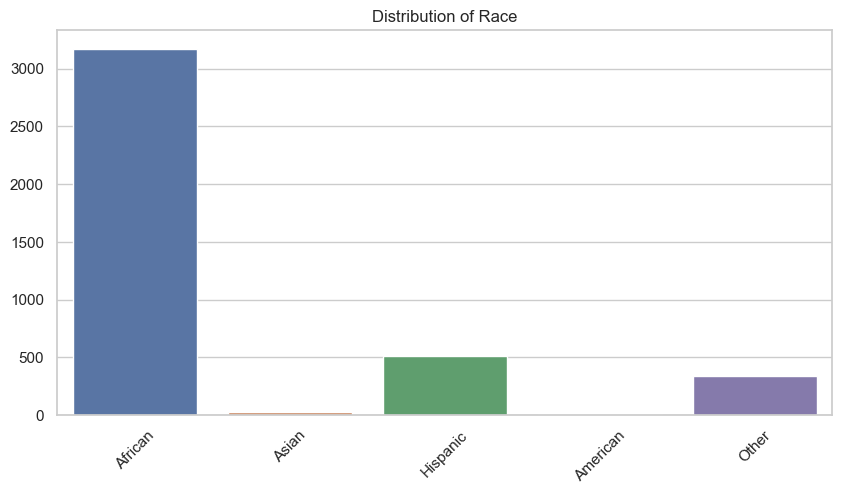

In [48]:
# Count the number of 1 values in the 'your_column' column
count_african = (df['African_American'] == 1).sum()
count_asian = (df['Asian'] == 1).sum()
count_hispanic = (df['Hispanic'] == 1).sum()
count_american = (df['Native_American'] == 1).sum()
count_other = (df['Other'] == 1).sum()

num_rows, num_columns = df.shape
count_age_between_25_45 = num_rows - count_age_below_25 - count_age_above_45


# Replace these with your actual data
column_names = ['African', 'Asian', 'Hispanic','American', 'Other']
counts_of_ones = [count_african, count_asian, count_hispanic, count_american, count_other]

# Create a bar plot to visualize the distribution
sns.set(style="whitegrid")
plt.figure(figsize=(10, 5))  # Set the figure size

# Use seaborn's barplot to create the distribution plot
sns.barplot(x=column_names, y=counts_of_ones)

# Customize the plot, including labels and title
plt.title('Distribution of Race')

# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=45)

# Show the plot
plt.show()


PREVALENCE

In [49]:
african_prevalence = count_african / num_rows
asian_prevalence = count_asian/num_rows
hispanic_prevalence = count_hispanic/num_rows
american_prevalence = count_american/num_rows
other_prevalence = count_other/num_rows

print(african_prevalence)
print(asian_prevalence)
print(hispanic_prevalence)
print(american_prevalence)
print(other_prevalence)

0.5144199611147116
0.005022683084899547
0.08246921581335062
0.0017822423849643552
0.05557355800388853


In [50]:
df.head()

,Two_yr_Recidivism,Number_of_Priors,score_factor,Age_Above_FourtyFive,Age_Below_TwentyFive,African_American,Asian,Hispanic,Native_American,Other,Female,Misdemeanor
0,0,0,0,1,0,0,0,0,0,1,0,0
1,1,0,0,0,0,1,0,0,0,0,0,0
2,1,4,0,0,1,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,0,1
4,1,14,1,0,0,0,0,0,0,0,0,0


In [51]:
X = df.drop(columns=['Two_yr_Recidivism','score_factor'])
y = df['Two_yr_Recidivism']

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y) #stratify mantem a mesma distribuição de classes que o set original
# train validation split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train)

In [52]:
y.value_counts().to_frame('Value').assign(perc = lambda x: x/x.sum()).round(2)

,Value,perc
0,3363,0.54
1,2809,0.46


LOGISTIC REGRESSION

In [53]:
lf = LogisticRegression()
lf.fit(X_train, y_train)

y_pred = lf.predict(X_val)

lf_report = classification_report(y_val,y_pred)

print(lf_report)

LogisticRegression()

              precision    recall  f1-score   support

           0       0.66      0.79      0.72       538
           1       0.67      0.52      0.58       450

    accuracy                           0.67       988
   macro avg       0.67      0.65      0.65       988
weighted avg       0.67      0.67      0.66       988



In [54]:
df.head()

,Two_yr_Recidivism,Number_of_Priors,score_factor,Age_Above_FourtyFive,Age_Below_TwentyFive,African_American,Asian,Hispanic,Native_American,Other,Female,Misdemeanor
0,0,0,0,1,0,0,0,0,0,1,0,0
1,1,0,0,0,0,1,0,0,0,0,0,0
2,1,4,0,0,1,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,0,1
4,1,14,1,0,0,0,0,0,0,0,0,0


PREPARE DATAFRAME FOR AEQUITAS

In [55]:
def map_age_group(df):
    if df['Age_Above_FourtyFive'] == 1:
        return 'Greater than 45'
    elif df['Age_Below_TwentyFive'] == 1:
        return 'Less than 25'
    else:
        return '25 - 45'
df['age_group'] = df.apply(map_age_group, axis=1)
# Drop the original age-related columns
#df.drop(['Age_Above_FourtyFive', 'Age_Below_TwentyFive'], axis=1, inplace=True)
df

,Two_yr_Recidivism,Number_of_Priors,score_factor,Age_Above_FourtyFive,Age_Below_TwentyFive,African_American,Asian,Hispanic,Native_American,Other,Female,Misdemeanor,age_group
0,0,0,0,1,0,0,0,0,0,1,0,0,Greater than 45
1,1,0,0,0,0,1,0,0,0,0,0,0,25 - 45
2,1,4,0,0,1,1,0,0,0,0,0,0,Less than 25
3,0,0,0,0,0,0,0,0,0,1,0,1,25 - 45
4,1,14,1,0,0,0,0,0,0,0,0,0,25 - 45
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6167,0,0,1,0,1,1,0,0,0,0,0,0,Less than 25
6168,0,0,0,0,1,1,0,0,0,0,0,0,Less than 25
6169,0,0,0,1,0,0,0,0,0,1,0,0,Greater than 45
6170,0,3,0,0,0,1,0,0,0,0,1,1,25 - 45


In [56]:
race_order = ['African_American', 'Asian', 'Hispanic', 'Native_American', 'Other']
df['race'] = df.apply(lambda row: next((race for race in race_order if row[race] == 1), None), axis=1)




In [57]:
df

,Two_yr_Recidivism,Number_of_Priors,score_factor,Age_Above_FourtyFive,Age_Below_TwentyFive,African_American,Asian,Hispanic,Native_American,Other,Female,Misdemeanor,age_group,race
0,0,0,0,1,0,0,0,0,0,1,0,0,Greater than 45,Other
1,1,0,0,0,0,1,0,0,0,0,0,0,25 - 45,African_American
2,1,4,0,0,1,1,0,0,0,0,0,0,Less than 25,African_American
3,0,0,0,0,0,0,0,0,0,1,0,1,25 - 45,Other
4,1,14,1,0,0,0,0,0,0,0,0,0,25 - 45,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6167,0,0,1,0,1,1,0,0,0,0,0,0,Less than 25,African_American
6168,0,0,0,0,1,1,0,0,0,0,0,0,Less than 25,African_American
6169,0,0,0,1,0,0,0,0,0,1,0,0,Greater than 45,Other
6170,0,3,0,0,0,1,0,0,0,0,1,1,25 - 45,African_American


In [62]:
df = df.dropna()
df

,Two_yr_Recidivism,Number_of_Priors,score_factor,Age_Above_FourtyFive,Age_Below_TwentyFive,African_American,Asian,Hispanic,Native_American,Other,Female,Misdemeanor,age_group,race
0,0,0,0,1,0,0,0,0,0,1,0,0,Greater than 45,Other
1,1,0,0,0,0,1,0,0,0,0,0,0,25 - 45,African_American
2,1,4,0,0,1,1,0,0,0,0,0,0,Less than 25,African_American
3,0,0,0,0,0,0,0,0,0,1,0,1,25 - 45,Other
5,0,3,0,0,0,0,0,0,0,1,0,0,25 - 45,Other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6167,0,0,1,0,1,1,0,0,0,0,0,0,Less than 25,African_American
6168,0,0,0,0,1,1,0,0,0,0,0,0,Less than 25,African_American
6169,0,0,0,1,0,0,0,0,0,1,0,0,Greater than 45,Other
6170,0,3,0,0,0,1,0,0,0,0,1,1,25 - 45,African_American


In [77]:
aequitas_data = pd.DataFrame()
aequitas_data['score'] = y_pred
aequitas_data['label_value'] = df['Two_yr_Recidivism']
aequitas_data['age'] = df['age_group']
aequitas_data['race'] = df['race']

aequitas_data['age'] = aequitas_data['age'].astype(str)
aequitas_data['race'] = aequitas_data['race'].astype(str)

aequitas_data.dropna()



,score,label_value,age,race
0,1,0.0,Greater than 45,Other
1,1,1.0,25 - 45,African_American
2,0,1.0,Less than 25,African_American
3,1,0.0,25 - 45,Other
5,0,0.0,25 - 45,Other
...,...,...,...,...
983,1,0.0,25 - 45,African_American
984,0,0.0,Less than 25,African_American
985,1,1.0,Less than 25,Hispanic
986,0,1.0,25 - 45,African_American


In [75]:
pip install aequitas

Note: you may need to restart the kernel to use updated packages.


In [80]:
import aequitas
from aequitas.preprocessing import preprocess_input_df

In [81]:
# *input_data* matches CLI input data norms.
df, _ = preprocess_input_df(aequitas_data)

In [82]:
from aequitas.group import Group

g = Group()
xtab, _ = g.get_crosstabs(df)

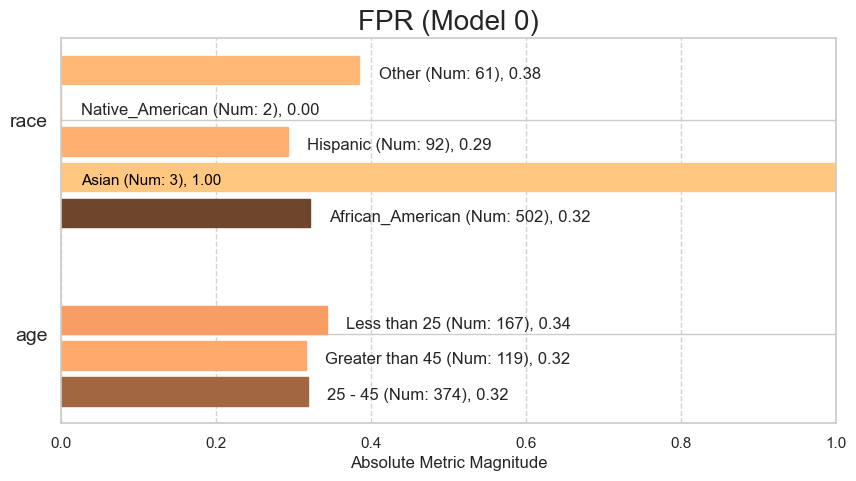

In [83]:
from aequitas.plotting import Plot

aqp = Plot()
fpr_plot = aqp.plot_group_metric(xtab, 'fpr')

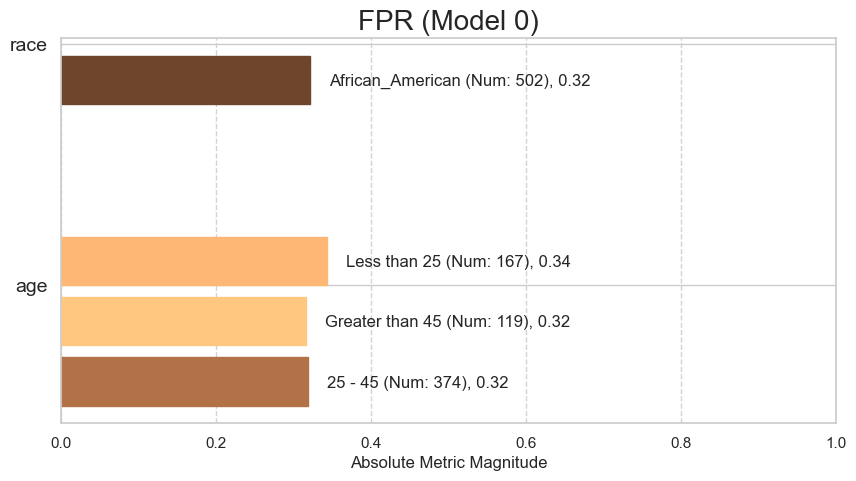

In [84]:
from aequitas.plotting import Plot

aqp = Plot()
fpr_plot = aqp.plot_group_metric(xtab, 'fpr', min_group_size=0.05)

In [107]:
from aequitas.bias import Bias

b = Bias()
bdf = b.get_disparity_predefined_groups(xtab, 
                    original_df=df, 
                    ref_groups_dict={'race':'African_American', 'age':'Less than 25'}, 
                    alpha=0.05, 
                    check_significance=False)

get_disparity_predefined_group()


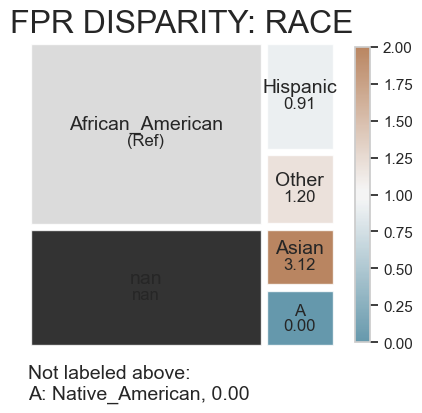

In [108]:
fpr_disparity = aqp.plot_disparity(bdf, group_metric='fpr_disparity', 
                                    attribute_name='race')

In [109]:
from aequitas.fairness import Fairness

f = Fairness()
fdf = f.get_group_value_fairness(bdf)

In [110]:
fpr_fairness = aqp.plot_fairness_group(fdf, group_metric='fpr', title=True)

ValueError: Cannot plot fpr, has NaN values.

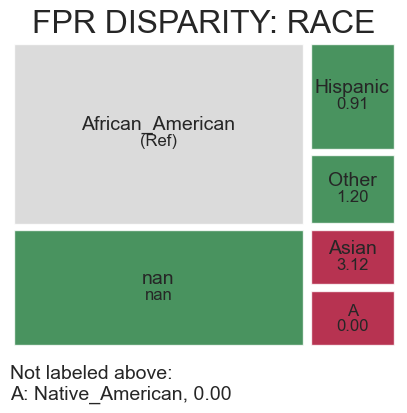

In [112]:
fpr_disparity_fairness = aqp.plot_fairness_disparity(fdf, group_metric='fpr', attribute_name='race')